<a href="https://colab.research.google.com/github/rkmad/microscopy_image_segmentation/blob/main/20231004_microscopy_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Use Facebook segment-anything to segment microscopy images
Based on:
https://github.com/facebookresearch/segment-anything

Images are phase contrast or electron micrographs of *Pseudomonas putida* in various growth conditions

In [6]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

!mkdir image_segmentation
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cs24cbgx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cs24cbgx
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘image_segmentation’: File exists
--2023-10-04 14:17:55--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg.1’

dog.jpg.1           100%[===================>]  97.51K  --.-KB/s    in 0.008s 

In [41]:
import torch
import torchvision
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
from google.colab import drive
drive.mount('/content/drive')

cuda
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
Mounted at /content/drive


In [ ]:
def resize_image(image, limit):
  """
  Resize image smaller if any dimension is > limit pixels
  To avoid RAM error, resize image if one or more dimension is >1600
  image: cv2 image object
  limit: integer pixel dimension limit, above which image will be downsized
  """
  print('Original Image Dimensions:' , image.shape)
  if max(image.shape) > limit:
    reduction_ratio= round(max(image.shape)/limit)
    width= int(image.shape[1]/reduction_ratio)
    height= int(image.shape[0]/reduction_ratio)
    dimension= (height,width)
    image = cv2.resize(image, dimension, interpolation = cv2.INTER_AREA)
    print('Final Dimensions : ', image.shape)
  return image


def show_anns(anns):
  """
  Show masks on image as distinct colors
  anns: masks from mask_generator.generate
  """
  if len(anns) == 0:
      return
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  print(f"Number of masks in image: {len(sorted_anns)}")
  ax = plt.gca()
  ax.set_autoscale_on(False)

  img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
  img[:,:,3] = 0
  for ann in sorted_anns:
      m = ann['segmentation']
      color_mask = np.concatenate([np.random.random(3), [0.35]])
      img[m] = color_mask
  ax.imshow(img)

In [129]:
# test default image
# image = cv2.imread('images/dog.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_name="mutante 11_004.tif"
#"bRK302_24h_0.1OD_0001.tif"
# "6.2plus24_0016.tif"
# "300_.tif"
#"309m63_0001.tif"
img_path= "../content/drive/My Drive/images_microscopy"
image = cv2.imread(f'{img_path}/{image_name}')
# For color images, reorder color
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image= resize_image(image, 1600)

Original Image Dimensions: (4096, 4096, 3)
Final Dimensions :  (1365, 1365, 3)


In [73]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [130]:
masks = mask_generator.generate(image)

Number of masks in image: 118


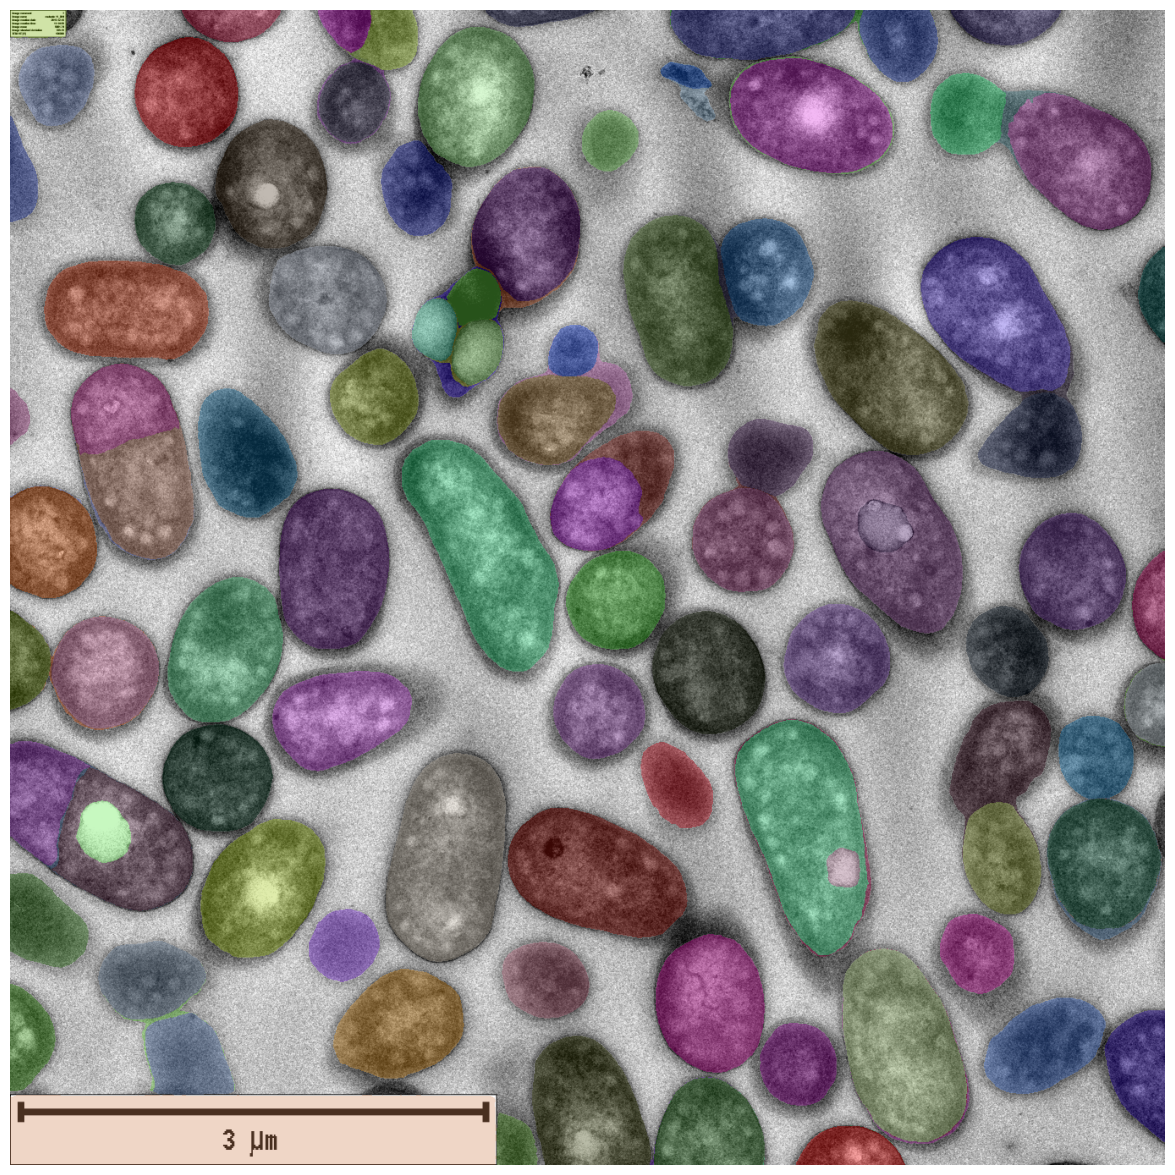

In [131]:
plt.figure(figsize=(15,15))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()